# Euclidean latent space model for Networks: Model $\mathbb{R}^3$

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.EuclideanM import *
from Modules.EuclideanV import *
from Modules.EuclideanC import *

## Network

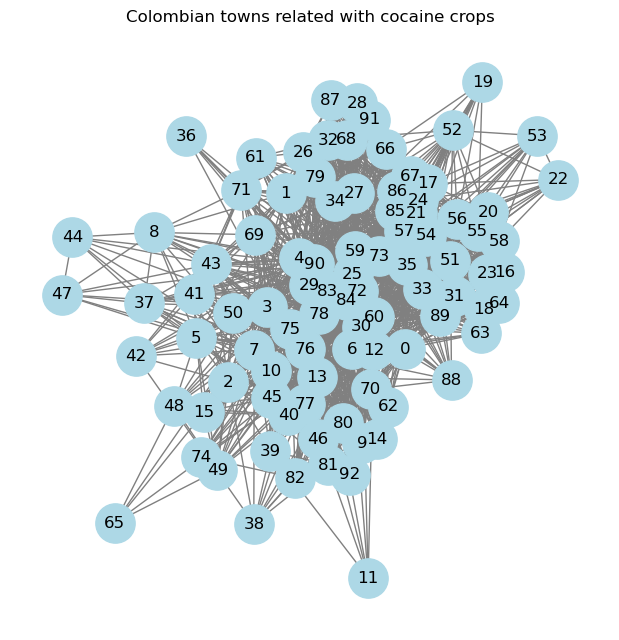

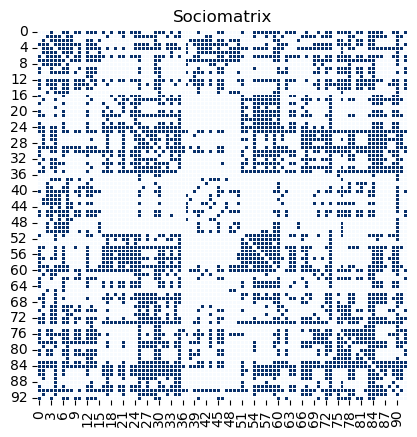

In [2]:
Y = np.loadtxt("colombiancropmatrix.txt", delimiter="\t")  
G = nx.from_numpy_array(Y)

node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Colombian towns related with cocaine crops")
plt.show()

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix")
plt.show()

## Latent space

### Frequentist inference

Initial log-likelihood: -12587.916846670056
Final log-likelihood: -5905.40256248986
Final alpha: 0.7926085437528574


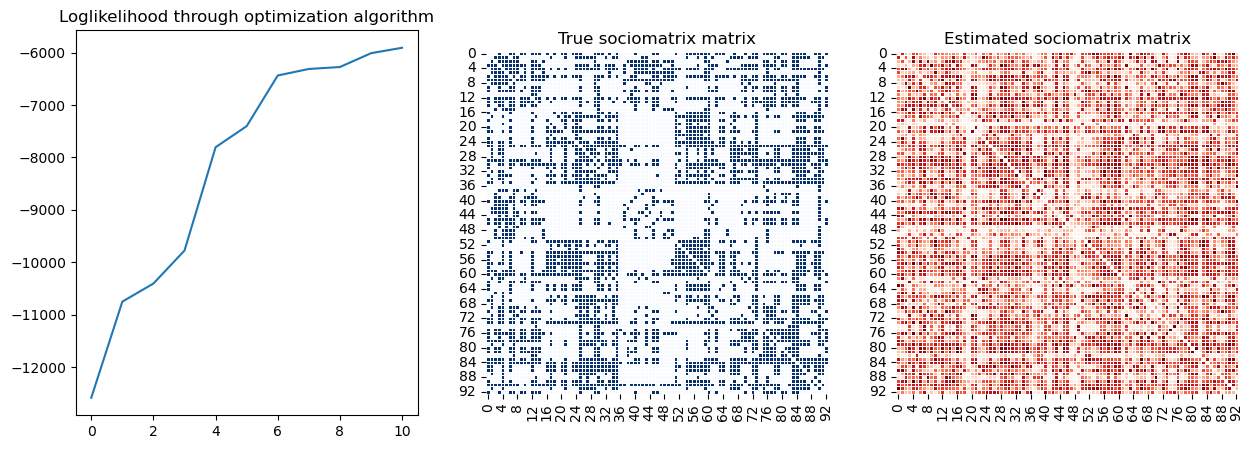

In [4]:

Z_init = np.random.randn(n, 3)
a_init = np.random.randn()

Z_ML, a_ML, historyZ, historya =  SearchingMLE(G, Z_init ,a_init,10)
print("Initial log-likelihood:", loglikelihood(G,Z_init,a_init))
print("Final log-likelihood:", loglikelihood(G,Z_ML,a_ML))
print("Final alpha:", a_ML)
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_ML[i,j] = expit(a_ML - 0.5 * np.linalg.norm(Z_ML[i] - Z_ML[j])**2)


df = pd.DataFrame(Z_ML, columns=['x', 'y', 'z'])
df['node'] = list(G.nodes)
fig = px.scatter_3d(df, x='x', y='y', z='z', text='node', opacity=0.9)
fig.update_layout(title='Maximum likelihood estimation of latent positions')
fig.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot([loglikelihood(G, historyZ[t],historya[t]) for t in range(len(historya))])
plt.title("Loglikelihood through optimization algorithm")
plt.subplot(1,3,2)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,3,3)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

### Bayesian inference

In [ ]:
# Execute HMC
number_of_samples = 10000
Z_init = Z_init
a_init = np.float64(a_init)

print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init))

samples_Z, samples_a, Hp, LogLp, acep_rate_history = hmc(G, Z_init, a_init, number_of_samples, 
                                                         epsilon_init=0.025, std_dev_Z=1.0,  std_dev_a=1.0,
                                                         percentage_warmup=0.01, Z0 = Z_ML)

# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM))

Log-L MLE: -0.20732574137639467
Log-L starter: -162.17769380361688
Number of samples: 2500
Number of parameters: 16
Number of iterations: 2750
Number of warmup iterations: 250


  9%|▉         | 250/2750 [09:00<1:09:20,  1.66s/it]

Final parameters: epsilon=0.0250, L=40, std_dev_Z=0.0905


100%|██████████| 2750/2750 [54:10<00:00,  1.18s/it]  

Acceptance rate: 0.55234
Log-L MAP: -48.14830721325257
Log-L CM: -39.84665257361504


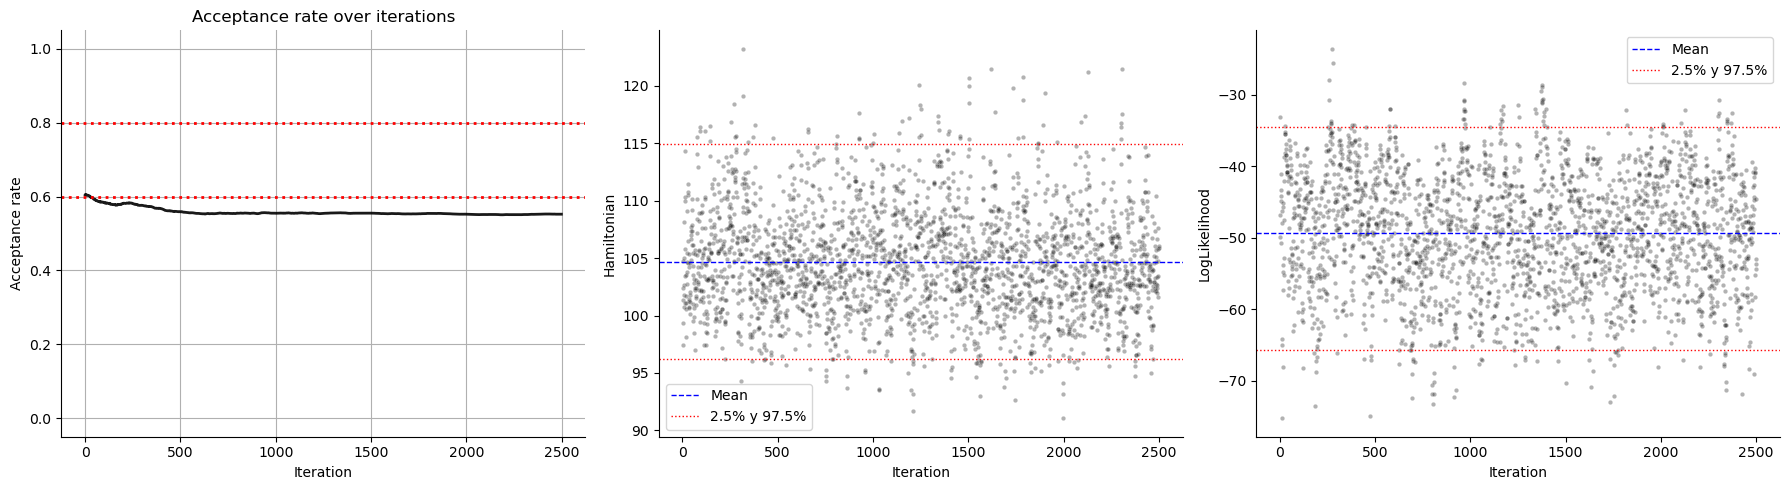

In [ ]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

In [ ]:
plot_Z_samples_3D(samples_Z[:50])

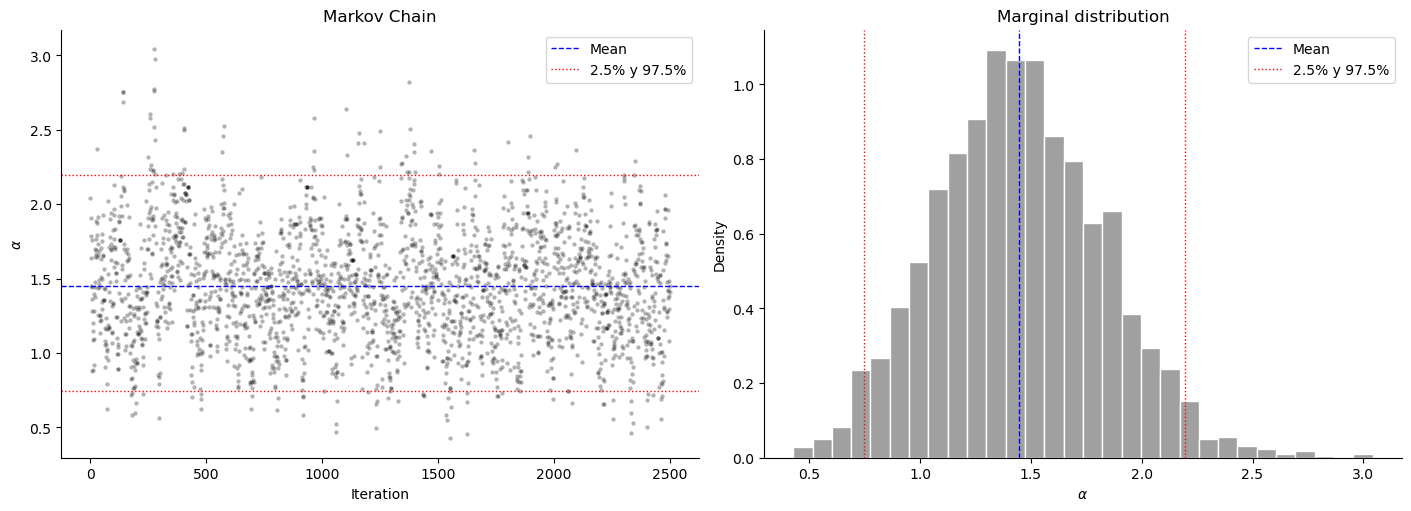

In [ ]:
plot_alpha(samples_a)

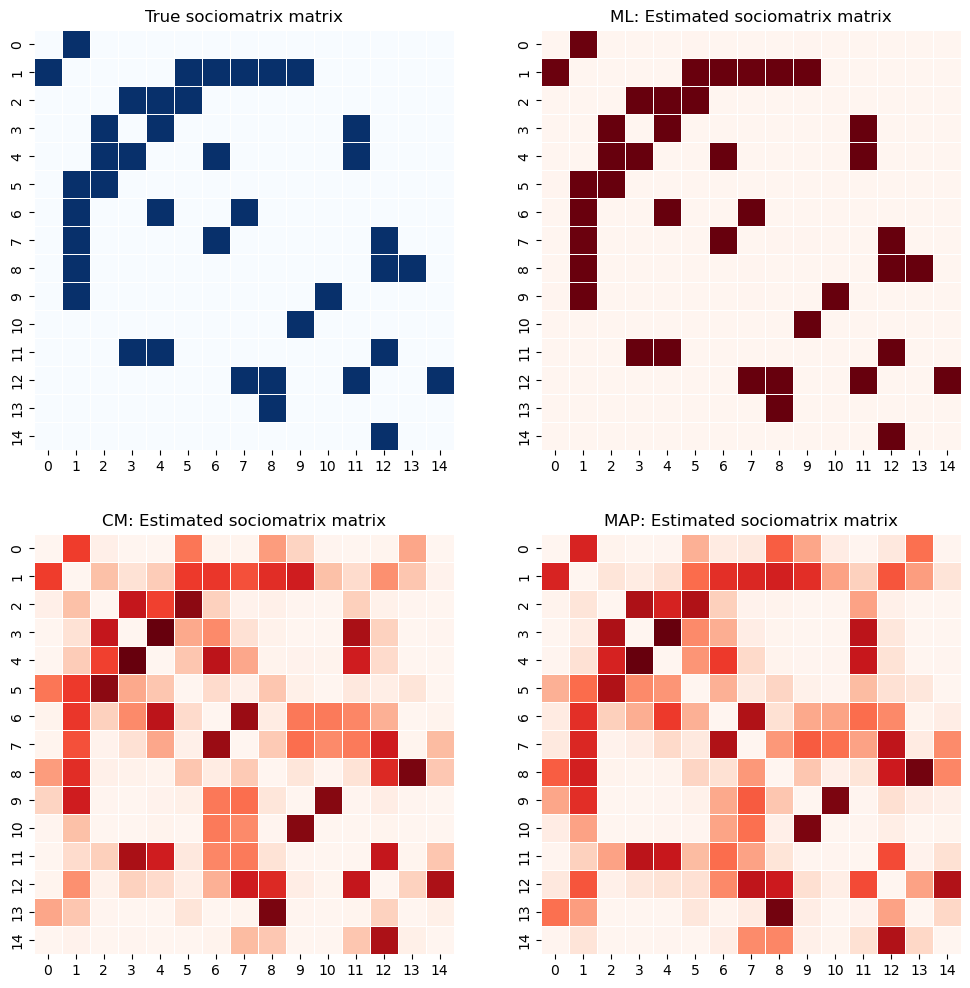

In [ ]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_CM[i,j] = expit(a_CM - 0.5 * np.linalg.norm(Z_CM[i] - Z_CM[j])**2)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_MAP[i,j] = expit(a_MAP - 0.5 * np.linalg.norm(Z_MAP[i] - Z_MAP[j])**2)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

In [ ]:
clustering3D(G,node_mapping, Z_ML, a_ML, Z_MAP, a_MAP, Z_CM, a_CM)

[[2, 3, 4, 5, 6, 11], [0, 1, 7, 8, 9, 10, 12, 13, 14]]

### Model Evaluation

#### Posterior predictive checking

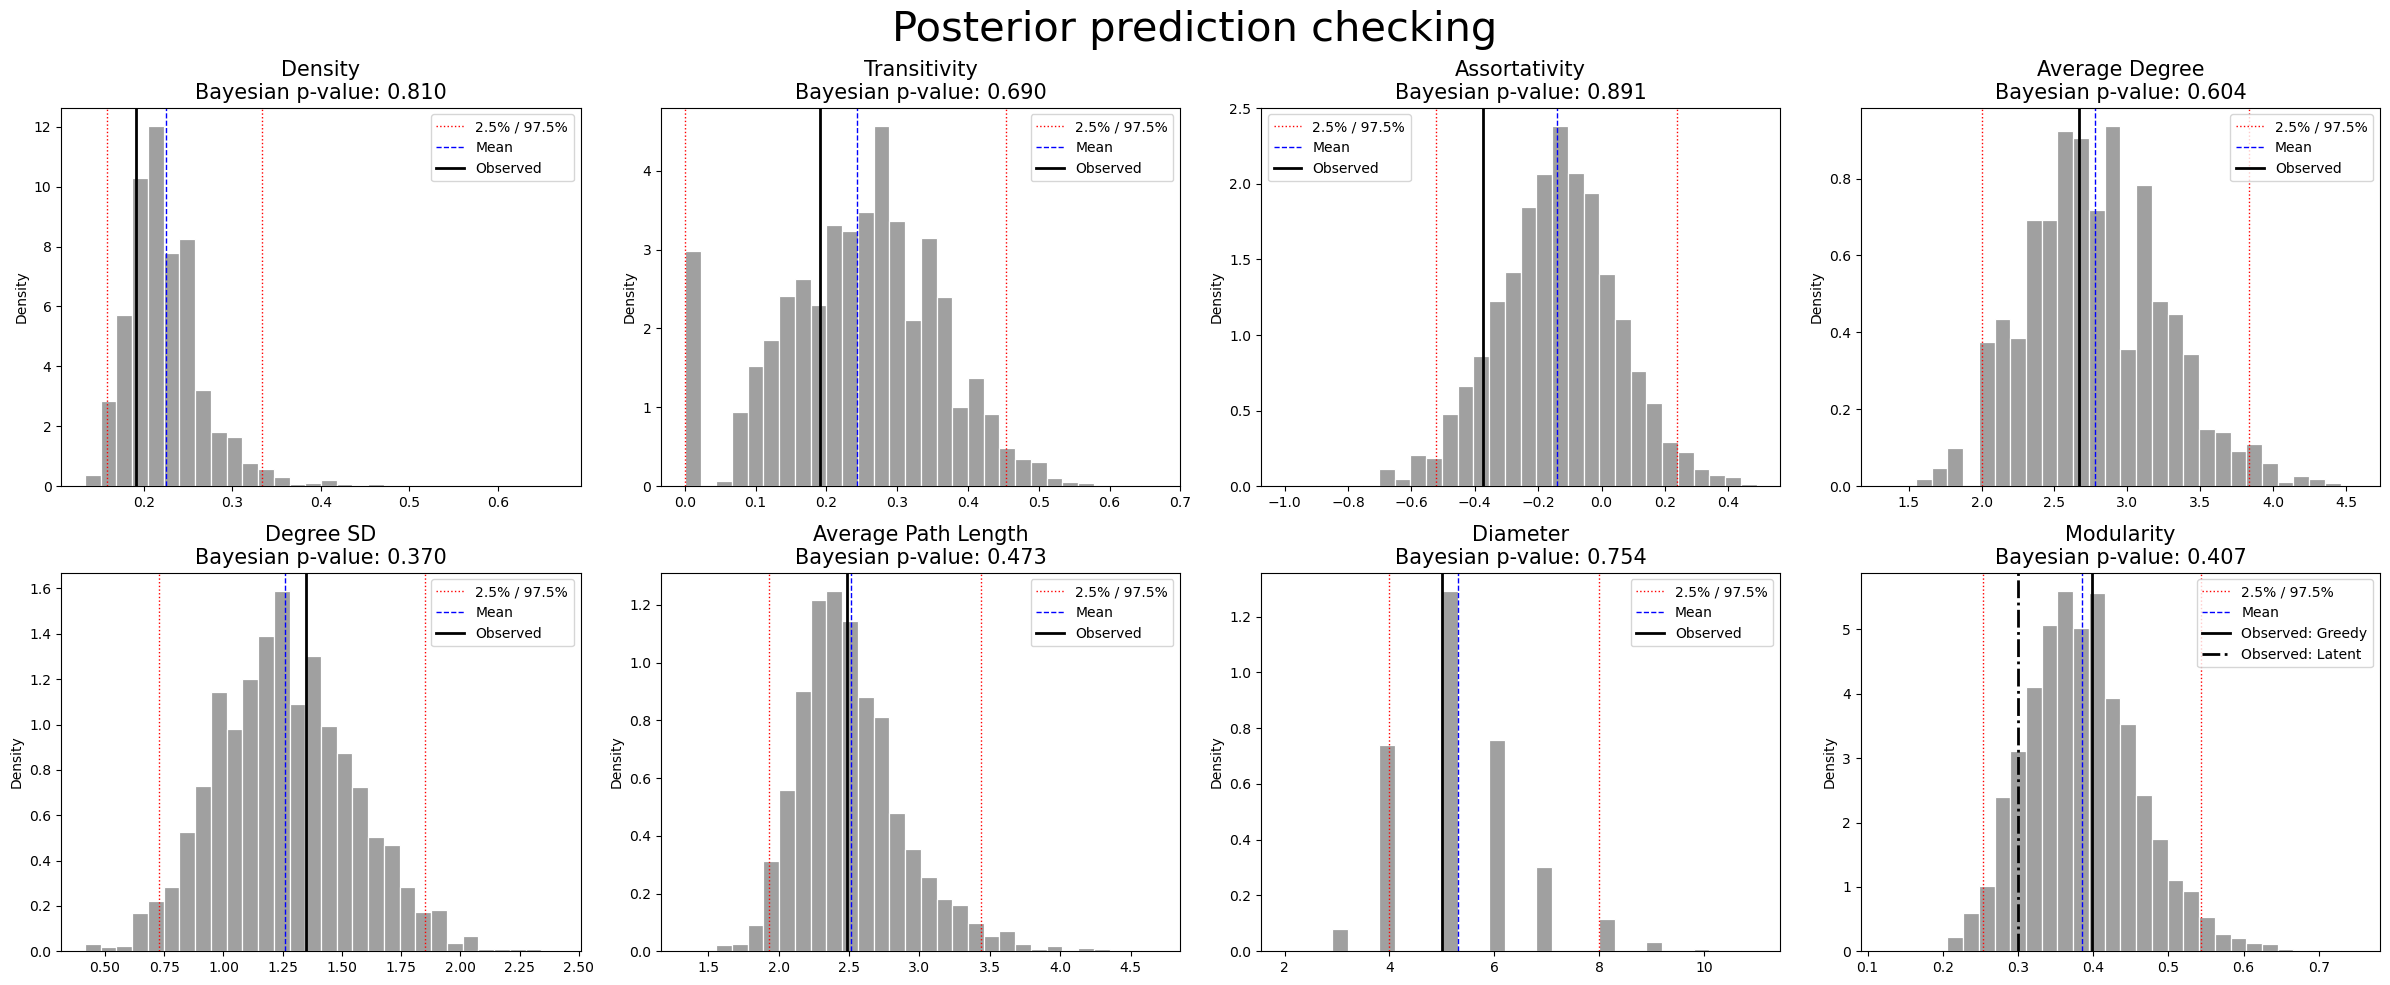

In [ ]:
predictive_check(G,samples_Z,samples_a)

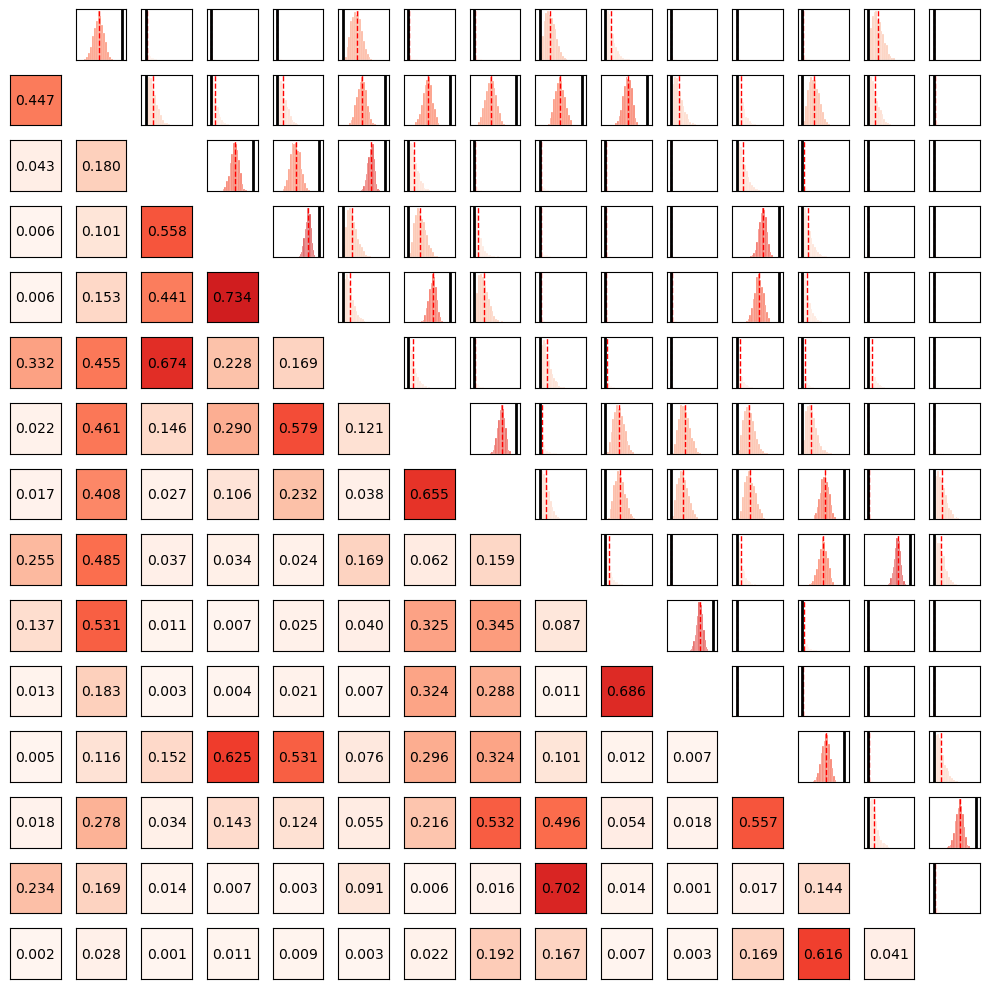

In [ ]:
plot_pairwise_sociomatrix(G,samples_Z,samples_a,Y)

#### Model comparison criteria

In [ ]:
log_lik = compute_log_likelihood(Y, samples_Z, samples_a)
waic = compute_WAIC(log_lik)
dic = compute_DIC(log_lik, Y, samples_Z, samples_a)


print(f"WAIC: {waic:.4f}")
print(f"DIC: {dic:.4f}")

WAIC: 91.4764
DIC: 95.9183


#### Prior predictive checking

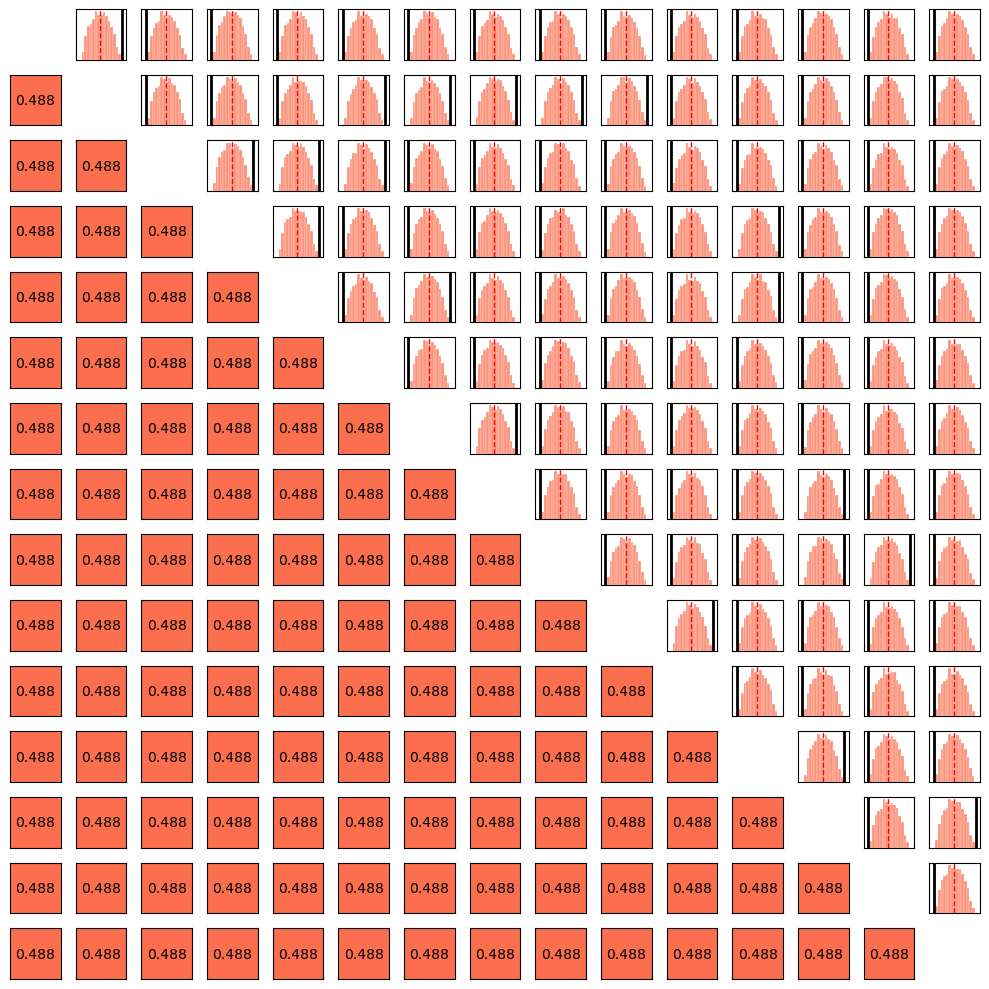

In [ ]:
samples_Z_prior = 0.1*np.random.randn(number_of_samples, n, 2)
samples_a_prior = np.random.randn(number_of_samples)
plot_pairwise_sociomatrix(G,samples_Z_prior,samples_a_prior,Y)

#### Prediction evaluation

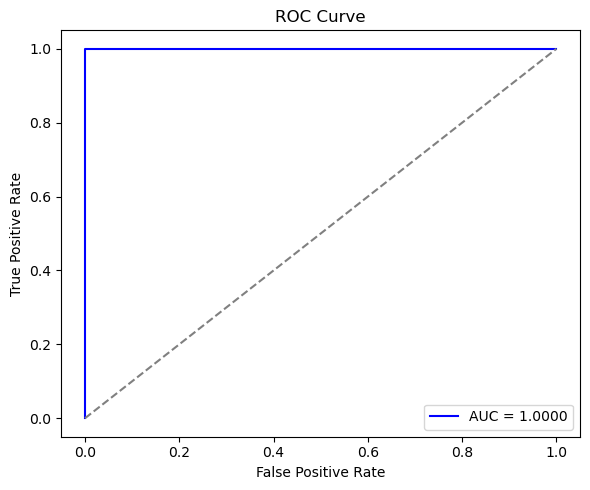

{'roc_auc': 1.0,
 'confusion_matrix': {'tp': 13, 'tn': 85, 'fp': 0, 'fn': 7},
 'accuracy': 0.9333333333333333,
 'precision': 1.0,
 'recall': 0.65,
 'f1_score': 0.787878787878788,
 'specificity': 1.0}

In [ ]:
roc_analysis(Y, posterior_connection_probs(samples_Z, samples_a))

## References

[1]